In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble.forest import _generate_sample_indices

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from tqdm import tqdm_notebook as tqdm

from joblib import Parallel, delayed

In [2]:
# Should use this class to generate CIFAR fig..
class LifelongForest:
    """
    Lifelong Forest class.
    """
    def __init__(self, acorn=None):
        """
        Two major things the Forest Class needs access to:
            1) the realized random forest model (self.models_ is a list of forests, 1 for each task)
            2) old data (to update posteriors when a new task is introduced)
        """
        self.models_ = []
        self.X_ = []
        self.y_ = []
        self.n_tasks = 0
        self.n_classes = None
        
        if acorn is not None:
            np.random.seed(acorn)
    
    def new_forest(self, X, y, n_estimators=200, max_samples=0.32,
                        bootstrap=True, max_depth=30, min_samples_leaf=1,
                        acorn=None):
        """
        Input
        X: an array-like object of features; X.shape == (n_samples, n_features)
        y: an array-like object of class labels; len(y) == n_samples
        n_estimators: int; number of trees to construct (default = 200)
        max_samples: float in (0, 1]: number of samples to consider when 
            constructing a new tree (default = 0.32)
        bootstrap: bool; If True then the samples are sampled with replacement
        max_depth: int; maximum depth of a tree
        min_samples_leaf: int; minimum number of samples in a leaf node
        
        Return
        model: a BaggingClassifier fit to X, y
        """
        
        if X.ndim == 1:
            raise ValueError('1d data will cause headaches down the road')
            
        if acorn is not None:
            np.random.seed(acorn)
            
        self.X_.append(X)
        self.y_.append(y)
            
        n = X.shape[0]
        K = len(np.unique(y))
        
        if self.n_classes is None:
            self.n_classes = K
        
        max_features = int(np.ceil(np.sqrt(X.shape[1])))

        model=BaggingClassifier(DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf,
                                                         max_features = max_features),
                                  n_estimators=n_estimators,
                                  max_samples=max_samples,
                                  bootstrap=bootstrap)

        model.fit(X, y)
        self.models_.append(model)
        self.n_tasks += 1
        self.n_classes = len(np.unique(y))
        
        return model
    
    
    def _get_leaves(self, estimator):
        """
        Internal function to get leaf node ids of estimator.
        
        Input
        estimator: a fit DecisionTreeClassifier
        
        Return
        leaf_ids: numpy array; an array of leaf node ids
        
        Usage
        _estimate_posteriors(..)
        """
        
        # adapted from https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
        n_nodes = estimator.tree_.node_count
        children_left = estimator.tree_.children_left
        children_right = estimator.tree_.children_right
        feature = estimator.tree_.feature
        threshold = estimator.tree_.threshold

        leaf_ids = []
        stack = [(0, -1)] 
        while len(stack) > 0:
            node_id, parent_depth = stack.pop()

            # If we have a test node
            if (children_left[node_id] != children_right[node_id]):
                stack.append((children_left[node_id], parent_depth + 1))
                stack.append((children_right[node_id], parent_depth + 1))
            else:
                leaf_ids.append(node_id)

        return np.array(leaf_ids)
    
    
    def _finite_sample_correction(self, class_probs, row_sums):
        """
        An internal function for finite sample correction of posterior estimation.
        
        Input
        class_probs: numpy array; array of posteriors to correct
        row_sums: numpy array; array of partition counts
        
        Output
        class_probs: numpy array; finite sample corrected posteriors
        
        Usage
        _estimate_posteriors(..)
        
        """
    
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1 / (2 * row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1 / (2 * row_sums[elem[0], None])
    
        return class_probs
    
    
    def _estimate_posteriors(self, test, representation=0, decider=0, subsample=1, acorn=None):
        """
        An internal function to estimate the posteriors.
        
        Input
        task_number: int; indicates which model in self.model_ to use
        test: array-like; test observation
        in_task: bool; True if test is an in-task observation(s)
        subsample: float in (0, 1]; proportion of out-of-task samples to use to
            estimate posteriors
            
        Return
        probs: numpy array; probs[i, k] is the probability of observation i
            being class k
            
        Usage
        predict(..)
        """
        
        if acorn is not None:
            acorn = np.random.seed(acorn)
            
        if representation==decider:
            in_task=True
        else:
            in_task=False
            
        train = self.X_[decider]
        y = self.y_[decider]
            
        model = self.models_[representation]

        n, d = train.shape
        
        if test.ndim > 1:
            m, d_ = test.shape
        else:
            m = len(test)
            d_ = 1
        
        size = len(np.unique(y))
        class_counts = np.zeros((m, size))
        for tree in model:
            # get out of bag indicies
            if in_task:
                prob_indices = _generate_unsampled_indices(tree.random_state, n)
                # in_bag_idx = _generate_sample_indices(tree.random_state, n) # this is not behaving as i expected
            else:
                prob_indices = np.random.choice(range(n), size=int(subsample*n), replace=False)

            leaf_nodes = self._get_leaves(tree)
            unique_leaf_nodes = np.unique(leaf_nodes)

            # get all node counts
            node_counts = tree.tree_.n_node_samples
            # get probs for eval samples
            posterior_class_counts = np.zeros((len(unique_leaf_nodes), size))

            for prob_index in prob_indices:
                temp_node = tree.apply(train[prob_index].reshape(1, -1)).item()
                posterior_class_counts[np.where(unique_leaf_nodes == temp_node)[0][0], y[prob_index]] += 1

            # total number of points in a node
            row_sums = posterior_class_counts.sum(axis=1)

            # no divide by zero
            row_sums[row_sums == 0] = 1

            # posteriors
            class_probs = (posterior_class_counts / row_sums[:, None])
            # posteriors with finite sampling correction

            class_probs = self._finite_sample_correction(class_probs, row_sums)

            # posteriors as a list
            class_probs.tolist()

            partition_counts = np.asarray([node_counts[np.where(unique_leaf_nodes == x)[0][0]] for x in tree.apply(test)])
            # get probability for out of bag samples
            eval_class_probs = [class_probs[np.where(unique_leaf_nodes == x)[0][0]] for x in tree.apply(test)]
            eval_class_probs = np.array(eval_class_probs)
            # find total elements for out of bag samples
            elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
            # store counts for each x (repeat fhis for each tree)
            class_counts += elems
        # calculate p(y|X = x) for all x's
        probs = class_counts / class_counts.sum(axis=1, keepdims=True)

        return probs


    def predict(self, test, representation=0, decider='all', subsample=1, acorn=None):
        """
        Predicts the class labels for each sample in test.
        
        Input
        test: array-like; either a 1d array of length n_features
            or a 2d array of shape (m, n_features) 
        task_number: int; task number 
        """
        
        size=len(np.unique(self.y_[decider]))
        sum_posteriors = np.zeros((test.shape[0], size))
        
        if representation is 'all':
            for i in range(self.n_tasks):
                sum_posteriors += self._estimate_posteriors(test,
                                                            i,
                                                            decider,
                                                            subsample,
                                                            acorn)
            
        else:
            sum_posteriors += self._estimate_posteriors(test,
                                                        representation,
                                                        decider,
                                                        subsample,
                                                        acorn)
                
        return np.argmax(sum_posteriors, axis=1)

In [3]:
def generate_2d_rotation(theta=0, acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
    
    R = np.array([
        [np.cos(theta), np.sin(theta)],
        [-np.sin(theta), np.cos(theta)]
    ])
    
    return R

def generate_parity(n, d=2, angle_params=None, acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
        
    X = np.random.uniform(-2, 2, size=(10*n, d))
    Y = (np.sum(X > 0, axis=1) % 2 == 0).astype(int)
    
    if d == 2:
        if angle_params is None:
            angle_params = np.random.uniform(0, 2*np.pi)
        R = generate_2d_rotation(angle_params)
        X = X @ R
        inds = (abs(X[:, 0]) < 1) + (abs(X[:, 1]) < 1)
        Y = Y[(abs(X[:, 0]) < 1) * (abs(X[:, 1]) < 1)][:n]
        X = X[(abs(X[:, 0]) < 1) * (abs(X[:, 1]) < 1)][:n]
        
        
    elif d==3:
        if angle_params is None:
            pass
        R = generate_3d_rotation(angle_params[0], angle_params[1], angle_params[2])
        X = X @ R
        Y = Y[(abs(X[:, 0]) < 1) * (abs(X[:, 1]) < 1) * (abs(X[:, 2]) < 1)][:n]
        X = X[(abs(X[:, 0]) < 1) * (abs(X[:, 1]) < 1) * (abs(X[:, 2]) < 1)][:n]
        
    else:
        raise ValueError("d=%i"%(d) + " not implemented.")
        
    return X, Y.astype(int)

# def generate_gaussian_parity(n, mean, cov_scale=1, angle_params=None, acorn=None):
#     if acorn is not None:
#         np.random.seed(acorn)
    
#     d = len(mean)
    
#     berns = 2*np.random.randint(2, size=(n, d)) - 1
#     Y = (np.sum(berns > 0, axis=1) % 2 == 0).astype(int)
    
#     means = mean * berns
#     X = np.array([np.random.multivariate_normal(i, cov_scale * np.eye(d)) for i in means]).reshape((n,d))
        
#     return X, Y

def generate_checkerboard(n, d=2, k=2, acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
        
    mnt = np.random.multinomial(n, 1/(4**k) * np.ones(4**k))
    cumsum = np.cumsum(mnt)
    cumsum = np.concatenate(([0], cumsum))
    
    Y = np.zeros(n)
    X = np.zeros((n, d))
    
    for i in range(2**k):
        for j in range(2**k):
            temp = np.random.uniform(-1, -1 + 1 / 4**(k-1), size=(mnt[i*(2**k) + j],2))
            temp[:, 0] += i*(1/4**(k-1))
            temp[:, 1] += j*(1/4**(k-1))
            
            X[cumsum[i*(2**k) + j]:cumsum[i*(2**k) + j + 1]] = temp
            
            if i % 2 == j % 2:
                Y[cumsum[i*(2**k) + j]:cumsum[i*(2**k) + j + 1]] = 0
            else:
                Y[cumsum[i*(2**k) + j]:cumsum[i*(2**k) + j + 1]] = 1
    X = 2*X + 1
            
    return X, Y.astype(int)

In [258]:
def generate_gaussian_parity(n, mean=np.array([-1, -1]), cov_scale=1, angle_params=None, k=1, acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
        
    d = len(mean)
    
    if mean[0] == -1 and mean[1] == -1:
        mean = mean + 1 / 2**k
    
    mnt = np.random.multinomial(n, 1/(4**k) * np.ones(4**k))
    cumsum = np.cumsum(mnt)
    cumsum = np.concatenate(([0], cumsum))
    
    Y = np.zeros(n)
    X = np.zeros((n, d))
    
    for i in range(2**k):
        for j in range(2**k):
            temp = np.random.multivariate_normal(mean, cov_scale * np.eye(d), 
                                                 size=mnt[i*(2**k) + j])
            temp[:, 0] += i*(1/2**(k-1))
            temp[:, 1] += j*(1/2**(k-1))
            
            X[cumsum[i*(2**k) + j]:cumsum[i*(2**k) + j + 1]] = temp
            
            if i % 2 == j % 2:
                Y[cumsum[i*(2**k) + j]:cumsum[i*(2**k) + j + 1]] = 0
            else:
                Y[cumsum[i*(2**k) + j]:cumsum[i*(2**k) + j + 1]] = 1
                
    if d == 2:
        if angle_params is None:
            angle_params = np.random.uniform(0, 2*np.pi)
            
        R = generate_2d_rotation(angle_params)
        X = X @ R
        
#         Y = Y[(abs(X[:, 0]) < 1) * (abs(X[:, 1]) < 1)][:n]
#         X = X[(abs(X[:, 0]) < 1) * (abs(X[:, 1]) < 1)][:n]
    else:
        raise ValueError('d=%i not implemented!'%(d))
       
    return X, Y.astype(int)

something


array([ 0.00340223, -0.00061026])

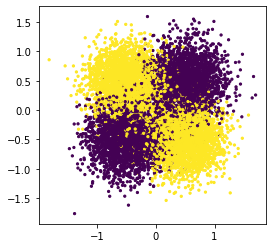

In [252]:
n=10000
X, Y = generate_gaussian_parity(n, cov_scale=0.1, k=1, angle_params=0)

perm = np.random.choice(n, n, replace=False)

fig, ax = plt.subplots(1,1)
ax.set_aspect('equal')
ax.scatter(X[perm,0], X[perm, 1], c=Y[perm], s=5)
np.mean(X, axis=0)

something


array([-0.01048054,  0.00046115])

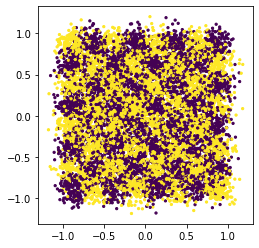

In [249]:
n=10000
X, Y = generate_gaussian_parity(n, cov_scale=0.01, k=3, angle_params=0)

perm = np.random.choice(n, n, replace=False)

fig, ax = plt.subplots(1,1)
ax.set_aspect('equal')
ax.scatter(X[perm,0], X[perm, 1], c=Y[perm], s=5)
np.mean(X, axis=0)

In [5]:
def lifelong_experiment(nR, nx, funcx, paramsx, nz, funcz, paramsz, m=500, subsample=0.32, return_posteriors=False, mesh_='unit square', acorn=None):
    if acorn is None:
        np.random.seed(acorn)
        
    errors = np.zeros((nR, 4))
    
    for i in range(nR):
    
        Tx = int(np.floor(np.sqrt(nx)))
        Tz = int(np.floor(np.sqrt(nz)))

        # Source task
        X, labelsX = funcx(nx, *paramsx)
        testX, test_labelsX = funcx(m, *paramsx)

        # Target task
        Z, labelsZ = funcz(nz, *paramsz)
        testZ, test_labelsZ = funcz(m, *paramsz)


        lifelong_forest = LifelongForest()

        if nx == 0 and nz == 0:
            raise ValueError('no samples')

        elif nx == 0:
            lifelong_forest.new_forest(Z, labelsZ, n_estimators=Tz)

            df_task2=lifelong_forest.predict(testZ, representation=1, decider=1)
            llf_task2=lifelong_forest.predict(testZ, representation='all', decider=1)

            errors[i,0] = 0.5
            errors[i,1] = 0.5  

            errors[i,2] = 1 - np.sum(df_task2 == test_labelsZ)/m
            errors[i,3] = 1 - np.sum(llf_task2 == test_labelsZ)/m

        if nz == 0:
            lifelong_forest.new_forest(X, labelsX, n_estimators=Tx)

            df_task1=lifelong_forest.predict(testX, representation=0, decider=0)
            llf_task1=lifelong_forest.predict(testX, representation='all', decider=0)

            errors[i,0] = 1 - np.sum(df_task1 == test_labelsX)/m
            errors[i,1] = 1 - np.sum(llf_task1 == test_labelsX)/m

            errors[i,2] = 0.5
            errors[i,3] = 0.5
        else:
            lifelong_forest.new_forest(X, labelsX, n_estimators=Tx)
            lifelong_forest.new_forest(Z, labelsZ, n_estimators=Tz)

            df_task1=lifelong_forest.predict(testX, representation=0, decider=0)
            llf_task1=lifelong_forest.predict(testX, representation='all', decider=0)

            df_task2=lifelong_forest.predict(testZ, representation=1, decider=1)
            llf_task2=lifelong_forest.predict(testZ, representation='all', decider=1)

            errors[i,0] = 1 - np.sum(df_task1 == test_labelsX)/m
            errors[i,1] = 1 - np.sum(llf_task1 == test_labelsX)/m 

            errors[i,2] = 1 - np.sum(df_task2 == test_labelsZ)/m
            errors[i,3] = 1 - np.sum(llf_task2 == test_labelsZ)/m
    
    if return_posteriors:
        import itertools
        # returns posteriors for a fixed mesh..
        if mesh_ == 'unit square':
            mesh_=np.array(list(itertools.product(np.arange(-1, 1+0.05, step=0.05), np.arange(-1, 1+0.05, step=0.05))))
        
        posteriors_structX_estX=lifelong_forest._estimate_posteriors(mesh_, representation=0, decider=0)
        posteriors_structZ_estX=lifelong_forest._estimate_posteriors(mesh_, representation=1, decider=0)
        
        posteriors_structZ_estZ=lifelong_forest._estimate_posteriors(mesh_, representation=1, decider=1)
        posteriors_structX_estZ=lifelong_forest._estimate_posteriors(mesh_, representation=0, decider=1)
                    
        return posteriors_structX_estX, posteriors_structZ_estX, posteriors_structZ_estZ, posteriors_structX_estZ
    else:
        return np.mean(errors, axis=0)

# (XOR, N-XOR)

In [259]:
n_mc = 50 # number of simulation repititions

n_xor = (100*np.arange(0.5, 2.25, step=0.25)).astype(int)
n_nxor = (100*np.arange(0.5, 10.25, step=0.25)).astype(int) # number of training samples 

m = 1000 # number of test samples each monte carlo iteration

mean_error_xor_nxor = np.zeros((4, len(n_xor)+len(n_nxor)))
std_error_xor_nxor = np.zeros((4, len(n_xor)+len(n_nxor)))

mean_te_xor_nxor = np.zeros((2, len(n_xor)+len(n_nxor)))
std_te_xor_nxor = np.zeros((2, len(n_xor)+len(n_nxor)))

nR=30

task1_func = generate_gaussian_parity
task1_params = (np.array([-1, -1]), 0.1, 0, 1)

task2_func = generate_gaussian_parity
task2_params= (np.array([-1, -1]), 0.1, np.pi/2, 1)

d = 2
for i, n1 in enumerate(tqdm(n_xor)):
    condensed_func = lambda x : lifelong_experiment(nR, n1, 
                                                    task1_func, task1_params, 
                                                    x, 
                                                    task2_func, task2_params, 
                                                    m=m)
    temp_errors = np.array(Parallel(n_jobs=-2)(delayed(condensed_func)(int(x)) for x in 0*np.ones(n_mc)))
    
    mean_error_xor_nxor[:, i] = np.mean(temp_errors, axis=0)
    std_error_xor_nxor[:, i] = np.std(temp_errors, ddof=1, axis=0) 
        
    mean_te_xor_nxor[0, i] = np.mean(temp_errors[:, 0] / temp_errors[:, 1])
    mean_te_xor_nxor[1, i] = np.mean(temp_errors[:, 0] / temp_errors[:, 1])
    
    std_te_xor_nxor[0, i] = np.std(temp_errors[:, 2] / temp_errors[:, 3], axis=0, ddof=1)
    std_te_xor_nxor[1, i] = np.std(temp_errors[:, 2] / temp_errors[:, 3], axis=0, ddof=1)
    
    if n1 == n_xor[-1]:
        for j, n2 in enumerate(tqdm(n_nxor)):
            condensed_func = lambda x : lifelong_experiment(nR, n1, 
                                                            task1_func, task1_params, 
                                                            x, 
                                                            task2_func, task2_params, 
                                                            m=m)
            temp_errors = np.array(Parallel(n_jobs=-2)(delayed(condensed_func)(int(x)) for x in n2*np.ones(n_mc)))
            
            mean_error_xor_nxor[:, i + j + 1] = np.mean(temp_errors, axis=0)
            std_error_xor_nxor[:, i + j + 1] = np.std(temp_errors, ddof=1, axis=0)
                        
            mean_te_xor_nxor[0, i + j + 1] = np.mean(temp_errors[:, 0] / temp_errors[:, 1], axis=0)
            mean_te_xor_nxor[1, i + j + 1] = np.mean(temp_errors[:, 2] / temp_errors[:, 3], axis=0)
            
            std_te_xor_nxor[0, i + j + 1] = np.std(temp_errors[:, 0] / temp_errors[:, 1], axis=0, ddof=1)
            std_te_xor_nxor[1, i + j + 1] = np.std(temp_errors[:, 2] / temp_errors[:, 3], axis=0, ddof=1)

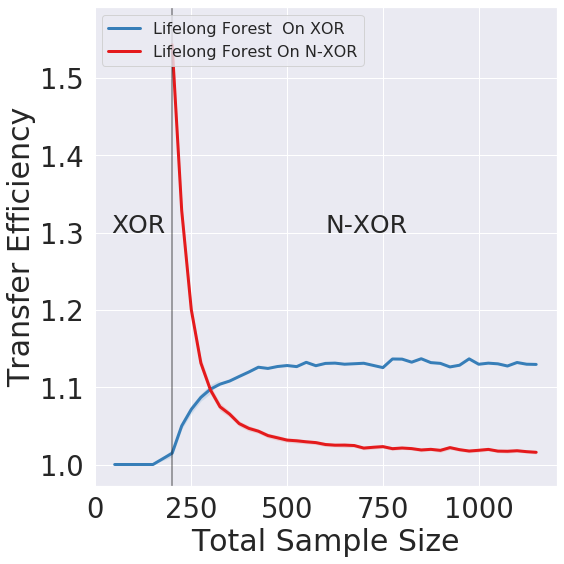

In [9]:
n1s = n_xor
n2s = n_nxor

ns = np.concatenate((n1s, n2s + n1s[-1]))

sns.set()

mean_error = mean_te_xor_nxor
std_error = std_te_xor_nxor / np.sqrt(n_mc)

TASK1='XOR'
TASK2='N-XOR'

algorithms = ['Uncertainty Forest Evaluated On %s'%(TASK1), 'Lifelong Forest (%s)'%(TASK1)]
algorithms = np.concatenate((algorithms, ['Uncertainty Forest (%s)'%(TASK2), 'Lifelong Forest (%s)'%(TASK2)]))

algorithms = ['Lifelong Forest  On %s'%(TASK1), 'Lifelong Forest On %s'%(TASK2)]


ls=['-', '--']

fontsize=30
labelsize=27.5

colors = sns.color_palette("Set1", n_colors = 9)
colors = [colors[1], colors[0]]



fig1 = plt.figure(figsize=(8,8))
ax1 = fig1.add_subplot(1,1,1)
# for i, algo in enumerate(algorithms):
ax1.plot(ns, mean_error[0], label=algorithms[0], c=colors[0], ls=ls[np.sum(0 > 1).astype(int)], lw=3)
ax1.fill_between(ns, 
        mean_error[0] + 1.96*std_error[0], 
        mean_error[0] - 1.96*std_error[0], 
        where=mean_error[1] + 1.96*std_error[0] >= mean_error[0] - 1.96*std_error[0], 
        facecolor=colors[0], 
        alpha=0.15,
        interpolate=True)

ax1.plot(ns[len(n1s):], mean_error[1, len(n1s):], label=algorithms[1], c=colors[1], ls=ls[np.sum(1 > 1).astype(int)], lw=3)
ax1.fill_between(ns[len(n1s):], 
        mean_error[1, len(n1s):] + 1.96*std_error[1, len(n1s):], 
        mean_error[1, len(n1s):] - 1.96*std_error[1, len(n1s):], 
        where=mean_error[1, len(n1s):] + 1.96*std_error[1, len(n1s):] >= mean_error[1, len(n1s):] - 1.96*std_error[1, len(n1s):], 
        facecolor=colors[1], 
        alpha=0.15,
        interpolate=True)

ax1.set_ylabel('Transfer Efficiency', fontsize=fontsize)
ax1.legend(loc='upper left', fontsize=16)
#         ax1.set_ylim(-0.01, 0.22)
ax1.set_xlabel('Total Sample Size', fontsize=fontsize)
ax1.tick_params(labelsize=labelsize)
#         ax1.set_yticks([0, 0.1, 0.2])
#     ax1.set_xticks([100, 200])
ax1.axvline(x=ns[len(n1s)], c='k', alpha=0.5)

ax1.text(40, 1.3, "%s"%(TASK1), fontsize=25)
ax1.text(600, 1.3, "%s"%(TASK2), fontsize=25)

plt.tight_layout()

plt.savefig('figures/gaussian-lifelong-experiments/lifelong_experiment_%s_%s_nmc%i_nD%i_n1%ito%i_n2%ito%i_d%i_m%i.png'%(TASK1, TASK2,
                                                                                                   n_mc, nR, n_xor[0],
                                                                                                   n_xor[-1], n_nxor[0],
                                                                                                   n_nxor[-1], d, m), dpi=500)
 

In [260]:
import pickle
TASK1 = 'XOR'
TASK2 = 'N-XOR'

pickle.dump(mean_error_xor_nxor, open('data/gaussian-lifelong-experiments/mean_error_%s_%s_nmc%i_nD%i_n1%ito%i_n2%ito%i_d%i_m%i.pkl'%(TASK1, TASK2,
                                                                                                   n_mc, nR, n_xor[0],
                                                                                                   n_xor[-1], n_nxor[0],
                                                                                                   n_nxor[-1], d, m), 
                                      'wb'))

pickle.dump(std_error_xor_nxor, open('data/gaussian-lifelong-experiments/std_error_%s_%s_nmc%i_nD%i_n1%ito%i_n2%ito%i_d%i_m%i.pkl'%(TASK1, TASK2,
                                                                                                   n_mc, nR, n_xor[0],
                                                                                                   n_xor[-1], n_nxor[0],
                                                                                                   n_nxor[-1], d, m), 
                                      'wb'))

pickle.dump(mean_te_xor_nxor, open('data/gaussian-lifelong-experiments/mean_te_%s_%s_nmc%i_nD%i_n1%ito%i_n2%ito%i_d%i_m%i.pkl'%(TASK1, TASK2,
                                                                                                   n_mc, nR, n_xor[0],
                                                                                                   n_xor[-1], n_nxor[0],
                                                                                                   n_nxor[-1], d, m), 
                                      'wb'))

pickle.dump(std_te_xor_nxor, open('data/gaussian-lifelong-experiments/std_te_%s_%s_nmc%i_nD%i_n1%ito%i_n2%ito%i_d%i_m%i.pkl'%(TASK1, TASK2,
                                                                                                   n_mc, nR, n_xor[0],
                                                                                                   n_xor[-1], n_nxor[0],
                                                                                                   n_nxor[-1], d, m), 
                                      'wb'))

# (XOR, R XOR)

In [261]:
n_mc = 50 # number of simulation repititions

n_xor = (100*np.arange(0.5, 2.25, step=0.25)).astype(int)
n_rxor = (100*np.arange(0.5, 10.25, step=0.25)).astype(int) # number of training samples 

m = 1000 # number of test samples each monte carlo iteration

mean_error_xor_rxor = np.zeros((4, len(n_xor)+len(n_rxor)))
std_error_xor_rxor = np.zeros((4, len(n_xor)+len(n_rxor)))

mean_te_xor_rxor = np.zeros((2, len(n_xor)+len(n_rxor)))
std_te_xor_rxor = np.zeros((2, len(n_xor)+len(n_rxor)))

task1_func = generate_gaussian_parity
task1_params = (np.array([-1, -1]), 0.1, 0, 1)

task2_func = generate_gaussian_parity
task2_params= (np.array([-1, -1]), 0.1, np.pi/4, 1)

nR=30

d = 2
for i, n1 in enumerate(tqdm(n_xor)):
    condensed_func = lambda x : lifelong_experiment(nR, n1, 
                                                            task1_func, task1_params, 
                                                            x, 
                                                            task2_func, task2_params, 
                                                            m=m)
    temp_errors = np.array(Parallel(n_jobs=-2)(delayed(condensed_func)(int(x)) for x in 0*np.ones(n_mc)))
    
    mean_error_xor_rxor[:, i] = np.mean(temp_errors, axis=0)
    std_error_xor_rxor[:, i] = np.std(temp_errors, ddof=1, axis=0) 
        
    mean_te_xor_rxor[0, i] = np.mean(temp_errors[:, 0] / temp_errors[:, 1])
    mean_te_xor_rxor[1, i] = np.mean(temp_errors[:, 0] / temp_errors[:, 1])
    
    std_te_xor_rxor[0, i] = np.std(temp_errors[:, 2] / temp_errors[:, 3], axis=0, ddof=1)
    std_te_xor_rxor[1, i] = np.std(temp_errors[:, 2] / temp_errors[:, 3], axis=0, ddof=1)
    
    if n1 == n_xor[-1]:
        for j, n2 in enumerate(tqdm(n_rxor)):
            condensed_func = lambda x : lifelong_experiment(nR, n1, 
                                                            task1_func, task1_params, 
                                                            x, 
                                                            task2_func, task2_params, 
                                                            m=m)
            temp_errors = np.array(Parallel(n_jobs=-2)(delayed(condensed_func)(int(x)) for x in n2*np.ones(n_mc)))
            
            mean_error_xor_rxor[:, i + j + 1] = np.mean(temp_errors, axis=0)
            std_error_xor_rxor[:, i + j + 1] = np.std(temp_errors, ddof=1, axis=0)
                        
            mean_te_xor_rxor[0, i + j + 1] = np.mean(temp_errors[:, 0] / temp_errors[:, 1], axis=0)
            mean_te_xor_rxor[1, i + j + 1] = np.mean(temp_errors[:, 2] / temp_errors[:, 3], axis=0)
            
            std_te_xor_rxor[0, i + j + 1] = np.std(temp_errors[:, 0] / temp_errors[:, 1], axis=0, ddof=1)
            std_te_xor_rxor[1, i + j + 1] = np.std(temp_errors[:, 2] / temp_errors[:, 3], axis=0, ddof=1)

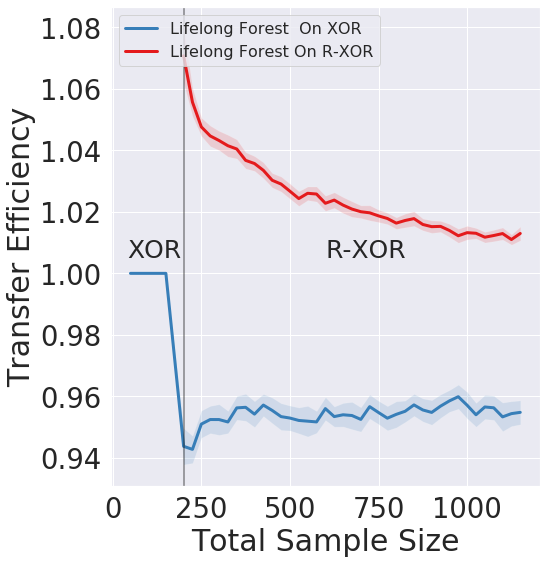

In [16]:
n1s = n_xor
n2s = n_rxor

ns = np.concatenate((n1s, n2s + n1s[-1]))

mean_error = mean_te_xor_rxor
std_error = std_te_xor_rxor / np.sqrt(n_mc)

# te = np.zeros((2, len(ns)))
# te[0] = 

TASK1='XOR'
TASK2='R-XOR'

algorithms = ['Uncertainty Forest Evaluated On %s'%(TASK1), 'Lifelong Forest (%s)'%(TASK1)]
algorithms = np.concatenate((algorithms, ['Uncertainty Forest (%s)'%(TASK2), 'Lifelong Forest (%s)'%(TASK2)]))

algorithms = ['Lifelong Forest  On %s'%(TASK1), 'Lifelong Forest On %s'%(TASK2)]


ls=['-', '--']

fontsize=30
labelsize=27.5

colors = sns.color_palette("Set1", n_colors = 9)
colors = [colors[1], colors[0]]



fig1 = plt.figure(figsize=(8,8))
ax1 = fig1.add_subplot(1,1,1)
# for i, algo in enumerate(algorithms):
ax1.plot(ns, mean_error[0], label=algorithms[0], c=colors[0], ls=ls[np.sum(0 > 1).astype(int)], lw=3)
ax1.fill_between(ns, 
        mean_error[0] + 1.96*std_error[0], 
        mean_error[0] - 1.96*std_error[0], 
        where=mean_error[1] + 1.96*std_error[0] >= mean_error[0] - 1.96*std_error[0], 
        facecolor=colors[0], 
        alpha=0.15,
        interpolate=True)

ax1.plot(ns[len(n1s):], mean_error[1, len(n1s):], label=algorithms[1], c=colors[1], ls=ls[np.sum(1 > 1).astype(int)], lw=3)
ax1.fill_between(ns[len(n1s):], 
        mean_error[1, len(n1s):] + 1.96*std_error[1, len(n1s):], 
        mean_error[1, len(n1s):] - 1.96*std_error[1, len(n1s):], 
        where=mean_error[1, len(n1s):] + 1.96*std_error[1, len(n1s):] >= mean_error[1, len(n1s):] - 1.96*std_error[1, len(n1s):], 
        facecolor=colors[1], 
        alpha=0.15,
        interpolate=True)

ax1.set_ylabel('Transfer Efficiency', fontsize=fontsize)
ax1.legend(loc='upper left', fontsize=16)
#         ax1.set_ylim(-0.01, 0.22)
ax1.set_xlabel('Total Sample Size', fontsize=fontsize)
ax1.tick_params(labelsize=labelsize)
#         ax1.set_yticks([0, 0.1, 0.2])
#     ax1.set_xticks([100, 200])
ax1.axvline(x=ns[len(n1s)], c='k', alpha=0.5)

ax1.text(40, 1.005, "%s"%(TASK1), fontsize=25)
ax1.text(600, 1.005, "%s"%(TASK2), fontsize=25)

plt.tight_layout()

plt.savefig('figures/gaussian-lifelong-experiments/lifelong_experiment_%s_%s_nmc%i_nD%i_n1%ito%i_n2%ito%i_d%i_m%i.png'%(TASK1, TASK2,
                                                                                                   n_mc, nR, n_xor[0],
                                                                                                   n_xor[-1], n_rxor[0],
                                                                                                   n_rxor[-1], d, m), dpi=500)
 

In [262]:
TASK1 = 'XOR'
TASK2 = 'R-XOR'

pickle.dump(mean_error_xor_rxor, open('data/gaussian-lifelong-experiments/mean_error_%s_%s_nmc%i_nD%i_n1%ito%i_n2%ito%i_d%i_m%i.pkl'%(TASK1, TASK2,
                                                                                                   n_mc, nR, n_xor[0],
                                                                                                   n_xor[-1], n_rxor[0],
                                                                                                   n_rxor[-1], d, m), 
                                      'wb'))

pickle.dump(std_error_xor_rxor, open('data/gaussian-lifelong-experiments/std_error_%s_%s_nmc%i_nD%i_n1%ito%i_n2%ito%i_d%i_m%i.pkl'%(TASK1, TASK2,
                                                                                                   n_mc, nR, n_xor[0],
                                                                                                   n_xor[-1], n_rxor[0],
                                                                                                   n_rxor[-1], d, m), 
                                      'wb'))

pickle.dump(mean_te_xor_rxor, open('data/gaussian-lifelong-experiments/mean_te_%s_%s_nmc%i_nD%i_n1%ito%i_n2%ito%i_d%i_m%i.pkl'%(TASK1, TASK2,
                                                                                                   n_mc, nR, n_xor[0],
                                                                                                   n_xor[-1], n_rxor[0],
                                                                                                   n_rxor[-1], d, m), 
                                      'wb'))

pickle.dump(std_te_xor_rxor, open('data/gaussian-lifelong-experiments/std_te_%s_%s_nmc%i_nD%i_n1%ito%i_n2%ito%i_d%i_m%i.pkl'%(TASK1, TASK2,
                                                                                                   n_mc, nR, n_xor[0],
                                                                                                   n_xor[-1], n_rxor[0],
                                                                                                   n_rxor[-1], d, m), 
                                      'wb'))

# (XOR, Chessboard)

In [263]:
n_mc = 50 # number of simulation repititions

n_xor = (100*np.arange(0.5, 2.25, step=0.25)).astype(int)
n_cb = (100*np.arange(0.5, 10.25, step=0.25)).astype(int) # number of training samples 

m = 1000 # number of test samples each monte carlo iteration

mean_error_xor_cb = np.zeros((4, len(n_xor)+len(n_cb)))
std_error_xor_cb = np.zeros((4, len(n_xor)+len(n_cb)))

mean_te_xor_cb = np.zeros((2, len(n_xor)+len(n_cb)))
std_te_xor_cb = np.zeros((2, len(n_xor)+len(n_cb)))

task1_func = generate_gaussian_parity
task1_params = (np.array([-1, -1]), 0.1, 0, 1)

task2_func = generate_gaussian_parity
task2_params= (np.array([-1, -1]), 0.01, 0, 3)

nR=30

d = 2
for i, n1 in enumerate(tqdm(n_xor)):
    condensed_func = lambda x : lifelong_experiment(nR, n1, 
                                                            task1_func, task1_params, 
                                                            x, 
                                                            task2_func, task2_params, 
                                                            m=m)
    temp_errors = np.array(Parallel(n_jobs=-2)(delayed(condensed_func)(int(x)) for x in 0*np.ones(n_mc)))
    
    mean_error_xor_cb[:, i] = np.mean(temp_errors, axis=0)
    std_error_xor_cb[:, i] = np.std(temp_errors, ddof=1, axis=0) 
        
    mean_te_xor_cb[0, i] = np.mean(temp_errors[:, 0] / temp_errors[:, 1])
    mean_te_xor_cb[1, i] = np.mean(temp_errors[:, 0] / temp_errors[:, 1])
    
    std_te_xor_cb[0, i] = np.std(temp_errors[:, 2] / temp_errors[:, 3], axis=0, ddof=1)
    std_te_xor_cb[1, i] = np.std(temp_errors[:, 2] / temp_errors[:, 3], axis=0, ddof=1)
    
    if n1 == n_xor[-1]:
        for j, n2 in enumerate(tqdm(n_cb)):
            condensed_func = lambda x : lifelong_experiment(nR, n1, 
                                                            task1_func, task1_params, 
                                                            x, 
                                                            task2_func, task2_params, 
                                                            m=m)
            temp_errors = np.array(Parallel(n_jobs=-2)(delayed(condensed_func)(int(x)) for x in n2*np.ones(n_mc)))
            
            mean_error_xor_cb[:, i + j + 1] = np.mean(temp_errors, axis=0)
            std_error_xor_cb[:, i + j + 1] = np.std(temp_errors, ddof=1, axis=0)
                        
            mean_te_xor_cb[0, i + j + 1] = np.mean(temp_errors[:, 0] / temp_errors[:, 1], axis=0)
            mean_te_xor_cb[1, i + j + 1] = np.mean(temp_errors[:, 2] / temp_errors[:, 3], axis=0)
            
            std_te_xor_cb[0, i + j + 1] = np.std(temp_errors[:, 0] / temp_errors[:, 1], axis=0, ddof=1)
            std_te_xor_cb[1, i + j + 1] = np.std(temp_errors[:, 2] / temp_errors[:, 3], axis=0, ddof=1)

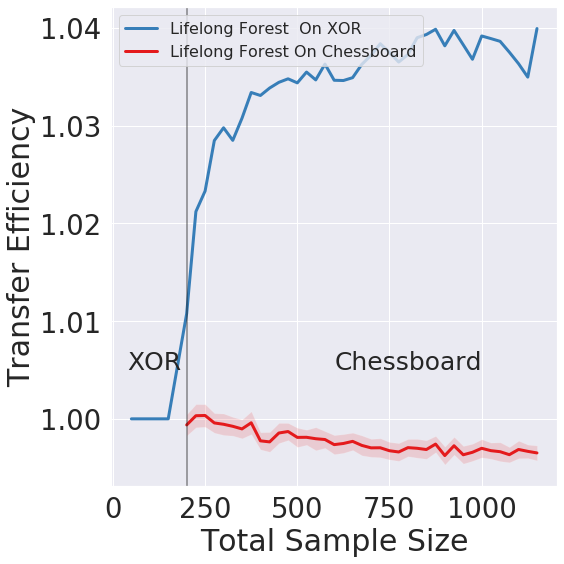

In [51]:
n1s = n_xor
n2s = n_cb

ns = np.concatenate((n1s, n2s + n1s[-1]))

mean_error = mean_te_xor_cb
std_error = std_te_xor_cb / np.sqrt(n_mc)

# te = np.zeros((2, len(ns)))
# te[0] = 

TASK1='XOR'
TASK2='Chessboard'

algorithms = ['Uncertainty Forest Evaluated On %s'%(TASK1), 'Lifelong Forest (%s)'%(TASK1)]
algorithms = np.concatenate((algorithms, ['Uncertainty Forest (%s)'%(TASK2), 'Lifelong Forest (%s)'%(TASK2)]))

algorithms = ['Lifelong Forest  On %s'%(TASK1), 'Lifelong Forest On %s'%(TASK2)]


ls=['-', '--']

fontsize=30
labelsize=27.5

colors = sns.color_palette("Set1", n_colors = 9)
colors = [colors[1], colors[0]]



fig1 = plt.figure(figsize=(8,8))
ax1 = fig1.add_subplot(1,1,1)
# for i, algo in enumerate(algorithms):
ax1.plot(ns, mean_error[0], label=algorithms[0], c=colors[0], ls=ls[np.sum(0 > 1).astype(int)], lw=3)
ax1.fill_between(ns, 
        mean_error[0] + 1.96*std_error[0], 
        mean_error[0] - 1.96*std_error[0], 
        where=mean_error[1] + 1.96*std_error[0] >= mean_error[0] - 1.96*std_error[0], 
        facecolor=colors[0], 
        alpha=0.15,
        interpolate=True)

ax1.plot(ns[len(n1s):], mean_error[1, len(n1s):], label=algorithms[1], c=colors[1], ls=ls[np.sum(1 > 1).astype(int)], lw=3)
ax1.fill_between(ns[len(n1s):], 
        mean_error[1, len(n1s):] + 1.96*std_error[1, len(n1s):], 
        mean_error[1, len(n1s):] - 1.96*std_error[1, len(n1s):], 
        where=mean_error[1, len(n1s):] + 1.96*std_error[1, len(n1s):] >= mean_error[1, len(n1s):] - 1.96*std_error[1, len(n1s):], 
        facecolor=colors[1], 
        alpha=0.15,
        interpolate=True)

ax1.set_ylabel('Transfer Efficiency', fontsize=fontsize)
ax1.legend(loc='upper left', fontsize=16)
#         ax1.set_ylim(-0.01, 0.22)
ax1.set_xlabel('Total Sample Size', fontsize=fontsize)
ax1.tick_params(labelsize=labelsize)
#         ax1.set_yticks([0, 0.1, 0.2])
#     ax1.set_xticks([100, 200])
ax1.axvline(x=ns[len(n1s)], c='k', alpha=0.5)

ax1.text(40, 1.005, "%s"%(TASK1), fontsize=25)
ax1.text(600, 1.005, "%s"%(TASK2), fontsize=25)

plt.tight_layout()

plt.savefig('figures/gaussian-lifelong-experiments/lifelong_experiment_%s_%s_nmc%i_nD%i_n1%ito%i_n2%ito%i_d%i_m%i.png'%(TASK1, TASK2,
                                                                                                   n_mc, nR, n_xor[0],
                                                                                                   n_xor[-1], n_cb[0],
                                                                                                   n_cb[-1], d, m), dpi=500)
 

In [264]:
TASK1 = 'XOR'
TASK2 = 'Chessboard'

pickle.dump(mean_error_xor_cb, open('data/gaussian-lifelong-experiments/mean_error_%s_%s_nmc%i_nD%i_n1%ito%i_n2%ito%i_d%i_m%i.pkl'%(TASK1, TASK2,
                                                                                                   n_mc, nR, n_xor[0],
                                                                                                   n_xor[-1], n_cb[0],
                                                                                                   n_cb[-1], d, m), 
                                      'wb'))

pickle.dump(std_error_xor_cb, open('data/gaussian-lifelong-experiments/std_error_%s_%s_nmc%i_nD%i_n1%ito%i_n2%ito%i_d%i_m%i.pkl'%(TASK1, TASK2,
                                                                                                   n_mc, nR, n_xor[0],
                                                                                                   n_xor[-1], n_cb[0],
                                                                                                   n_cb[-1], d, m), 
                                      'wb'))

pickle.dump(mean_te_xor_cb, open('data/gaussian-lifelong-experiments/mean_te_%s_%s_nmc%i_nD%i_n1%ito%i_n2%ito%i_d%i_m%i.pkl'%(TASK1, TASK2,
                                                                                                   n_mc, nR, n_xor[0],
                                                                                                   n_xor[-1], n_cb[0],
                                                                                                   n_cb[-1], d, m), 
                                      'wb'))

pickle.dump(std_te_xor_cb, open('data/gaussian-lifelong-experiments/std_te_%s_%s_nmc%i_nD%i_n1%ito%i_n2%ito%i_d%i_m%i.pkl'%(TASK1, TASK2,
                                                                                                   n_mc, nR, n_xor[0],
                                                                                                   n_xor[-1], n_cb[0],
                                                                                                   n_cb[-1], d, m), 
                                      'wb'))

In [ ]:
n_mc = 50 # number of simulation repititions

n_cb = (100*np.arange(0.5, 2.25, step=0.25)).astype(int)
n_xor = (100*np.arange(0.5, 10.25, step=0.25)).astype(int) # number of training samples 

m = 1000 # number of test samples each monte carlo iteration

mean_error_cb_xor = np.zeros((4, len(n_cb)+len(n_xor)))
std_error_cb_xor = np.zeros((4, len(n_cb)+len(n_xor)))

mean_te_cb_xor = np.zeros((2, len(n_xor)+len(n_cb)))
std_te_cb_xor = np.zeros((2, len(n_xor)+len(n_cb)))

task1_func = generate_gaussian_parity
task1_params = (np.array([-1, -1]), 0.01, 0, 3)

task2_func = generate_gaussian_parity
task2_params= (np.array([-1, -1]), 0.1, 0, 1)

nR=30

d = 2
for i, n1 in enumerate(tqdm(n_cb)):
    condensed_func = lambda x : lifelong_experiment(nR, n1, 
                                                            task1_func, task1_params, 
                                                            x, 
                                                            task2_func, task2_params, 
                                                            m=m)
    temp_errors = np.array(Parallel(n_jobs=-2)(delayed(condensed_func)(int(x)) for x in 0*np.ones(n_mc)))
    
    mean_error_cb_xor[:, i] = np.mean(temp_errors, axis=0)
    std_error_cb_xor[:, i] = np.std(temp_errors, ddof=1, axis=0) 
        
    mean_te_cb_xor[0, i] = np.mean(temp_errors[:, 0] / temp_errors[:, 1])
    mean_te_cb_xor[1, i] = np.mean(temp_errors[:, 0] / temp_errors[:, 1])
    
    std_te_cb_xor[0, i] = np.std(temp_errors[:, 2] / temp_errors[:, 3], axis=0, ddof=1)
    std_te_cb_xor[1, i] = np.std(temp_errors[:, 2] / temp_errors[:, 3], axis=0, ddof=1)
    
    if n1 == n_cb[-1]:
        for j, n2 in enumerate(tqdm(n_xor)):
            condensed_func = lambda x : lifelong_experiment(nR, n1, 
                                                            task1_func, task1_params, 
                                                            x, 
                                                            task2_func, task2_params, 
                                                            m=m)
            temp_errors = np.array(Parallel(n_jobs=-2)(delayed(condensed_func)(int(x)) for x in n2*np.ones(n_mc)))
            
            mean_error_cb_xor[:, i + j + 1] = np.mean(temp_errors, axis=0)
            std_error_cb_xor[:, i + j + 1] = np.std(temp_errors, ddof=1, axis=0)
                        
            mean_te_cb_xor[0, i + j + 1] = np.mean(temp_errors[:, 0] / temp_errors[:, 1], axis=0)
            mean_te_cb_xor[1, i + j + 1] = np.mean(temp_errors[:, 2] / temp_errors[:, 3], axis=0)
            
            std_te_cb_xor[0, i + j + 1] = np.std(temp_errors[:, 0] / temp_errors[:, 1], axis=0, ddof=1)
            std_te_cb_xor[1, i + j + 1] = np.std(temp_errors[:, 2] / temp_errors[:, 3], axis=0, ddof=1)

In [ ]:
import pickle

TASK1 = 'Chessboard'
TASK2 = 'XOR'

n_mc = 50 # number of simulation repititions

n_cb = (100*np.arange(0.5, 2.25, step=0.25)).astype(int)
n_xor = (100*np.arange(0.5, 10.25, step=0.25)).astype(int) # number of training samples 

m = 1000 # number of test samples each monte carlo iteration

nR=30

d = 2
pickle.dump(mean_error_cb_xor, open('data/gaussian-lifelong-experiments/mean_error_%s_%s_nmc%i_nD%i_n1%ito%i_n2%ito%i_d%i_m%i.pkl'%(TASK1, TASK2,
                                                                                                   n_mc, nR, n_cb[0],
                                                                                                   n_cb[-1], n_xor[0],
                                                                                                   n_xor[-1], d, m), 
                                      'wb'))

pickle.dump(std_error_cb_xor, open('data/gaussian-lifelong-experiments/std_error_%s_%s_nmc%i_nD%i_n1%ito%i_n2%ito%i_d%i_m%i.pkl'%(TASK1, TASK2,
                                                                                                   n_mc, nR, n_cb[0],
                                                                                                   n_cb[-1], n_xor[0],
                                                                                                   n_xor[-1], d, m), 
                                      'wb'))

pickle.dump(mean_te_cb_xor, open('data/gaussian-lifelong-experiments/mean_te_%s_%s_nmc%i_nD%i_n1%ito%i_n2%ito%i_d%i_m%i.pkl'%(TASK1, TASK2,
                                                                                                   n_mc, nR, n_cb[0],
                                                                                                   n_cb[-1], n_xor[0],
                                                                                                   n_xor[-1], d, m), 
                                      'wb'))

pickle.dump(std_te_cb_xor, open('data/gaussian-lifelong-experiments/std_te_%s_%s_nmc%i_nD%i_n1%ito%i_n2%ito%i_d%i_m%i.pkl'%(TASK1, TASK2,
                                                                                                   n_mc, nR, n_cb[0],
                                                                                                   n_cb[-1], n_xor[0],
                                                                                                   n_xor[-1], d, m), 
                                      'wb'))